## 이메일 데이터 곱씹어보기 

## 이메일로 보는 나의 개발자 생활 4.5년

* 기존에 분석했던 "이메일로 분석해 보는 나의 3년"을 brunch로 옮기면서 분석 내용을 추가 하였다. 

1. 이메일의 스탯 탐색을 통해 회사에 적응하는 정도 또는 과정 그리고 패턴에 대하여 알아본다. 
2. 이메일의 제목의 Topic분석으로 통해 분기별 이슈를 분석한다. 
3. 주고 받는 E-Mail 대상자를 통해 동료간의 관계 네트워크를 분석한다. 

In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
from datetime import datetime
from PIL import Image
from os import path
import matplotlib.patches as mpatches
import random

%matplotlib inline  

sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.4,
        rc = {'font.size': 12, 'font.family':'NanumGothic'})

* 사용될 색상 팔렛트

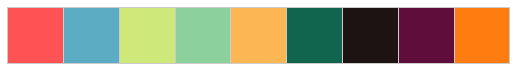

In [2]:
col_pal = "#FF5254 #5CACC4 #CEE879 #8CD19D #FCB653 #11644D #1D1313 #5F0D3B #FF7D10".split()
sns.palplot(col_pal)

---
## 데이터 준비
 
 나의 outlook에 있는 이메일에서 보낸사람, 받는사람, 보낸시간, 제목의 정보만 file로 다운로드를 하자. outlook에는 기본적인 내보내기를 제공하는데 이 내보내기 기능에서는 보낸시간 정보 필드를 추가 할 수 없기 때문에 어쩔수 없이 보낸 시간까지 파일로 내보낼수 있는 서드 파티 툴 인 Codetwo(http://www.codetwo.com/freeware/outlook-export/)를이용하였다.
* 데이터 Columns = ['timestamp', 'from', 'cc', 'to', 'subject']

In [3]:
!head -n 3 ./resource/email-data-20161116/send-mail.csv

In [4]:
my_positions = set('아프리카TV전직원;서비스기술연구소;기술연구소;기반기술팀;최규민;파이_최규민'.split(';'))
def incloudeMe(entries):
    if type(entries)==str:
        entries = [entries]
        
    for entry in entries:
        if entry in my_positions:
            return True
    return False

In [5]:
# 데이터 로드 
recv_ds = pd.read_csv("./resource/email-data/receive-mail.csv", 
            header=None, names=['timestamp', 'from', 'cc', 'to', 'subject'])

sent_ds = pd.read_csv("./resource/email-data/send-mail.csv", 
            header=None, names=['timestamp', 'from', 'cc', 'to', 'subject'])

# 혼합된 데이터 타입 변환 
recv_ds = recv_ds.astype(str)
sent_ds = sent_ds.astype(str)

# timestamp type을 datetime으로 변환하자 
def str2datetime(s):
    return datetime.strptime( s.replace('오후','pm').replace('오전','am')
                      ,  '%Y-%m-%d %p %I:%M:%S' )

recv_ds['timestamp'] = recv_ds['timestamp'].apply( str2datetime ) 
recv_ds['dir'] = recv_ds.to.apply(lambda x : u'받은메일' if incloudeMe((x).split(';')) else u'참조메일' )
sent_ds['timestamp'] = sent_ds['timestamp'].apply( str2datetime ) 
sent_ds['dir'] = u'보낸메일'

# timestamp date, time으로 분리해서 처리하자 
recv_ds['hour'] = recv_ds['timestamp'].apply( lambda x : x.hour+ x.minute/60)
sent_ds['hour'] = sent_ds['timestamp'].apply( lambda x : x.hour+ x.minute/60)
recv_ds['date'] = recv_ds['timestamp'].apply(datetime.date)
sent_ds['date'] = sent_ds['timestamp'].apply(datetime.date)
mail_ds = pd.concat([recv_ds, sent_ds])


# 분석을 쉽게하는 필드 추가 
mail_ds['year_days'] = mail_ds['timestamp'].apply(lambda x : (x-datetime(x.year,1,1)).days)
mail_ds['days'] = mail_ds['timestamp'].apply(lambda x : (x-datetime(2012,1,1)).days)
mail_ds['total'] = 'total'
mail_ds['year'] = mail_ds['timestamp'].apply(lambda x : (x.year))
mail_ds['month'] = mail_ds['timestamp'].apply(lambda x : (x.month))
mail_ds['receivers'] = mail_ds['to'].apply(lambda x: len(x.split(';')))
mail_ds['from_to'] = (mail_ds['from'] + ';' + mail_ds['to']).apply(lambda x:(str(x).split(';')))

# 
## 동일한 메일 스레드를 하나의 묶기위해 메일의 Prefix제거 
## 귀찮아서 Prefix단어 일괄제거 
title_prefixes = "RE:|RE:|Fwd:|FW:|Re:|Accepted:|회신:|수락:|수락됨:".split('|')
def clearSubjectPrefix(subject):
    for prefix in title_prefixes:
        subject = subject.replace(prefix,'')
    subject = subject.lstrip()
    return subject

mail_ds['thread_subject'] = mail_ds['subject'].apply( clearSubjectPrefix )

# 참조 메일 제외 
full_mail_ds = mail_ds
mail_ds = mail_ds[mail_ds['dir']!=u'참조메일']

# initialize index 
mail_ds = mail_ds.sort('timestamp').reset_index(drop=True)

In [6]:
mail_ds[['timestamp', 'from', 'cc', 'to', 'subject']].head()

,timestamp,from,cc,to,subject
0,2012-03-23 14:01:14,김 진기,nan,봉 승태;기반기술팀,RE: 게시판 리뷰관련
1,2012-03-26 17:53:32,성 주현,nan,플랫폼개발팀;기반기술팀,RE: [위키] 위키 에디터 테스트 요청드립니다.
2,2012-03-28 13:31:40,곽 정웅,nan,플랫폼개발팀;기반기술팀,[위키] 스킨 추가했습니다
3,2012-03-30 20:58:56,손 지영,nan,최 동근;플랫폼개발팀;기반기술팀,모두 감사드립니다
4,2012-04-10 13:21:49,김 아름,nan,기반기술팀,아프리카 시스템 구성 리뷰


---
## 1. E-Mail Stat 탐색

In [7]:
daily_send_stats = mail_ds[mail_ds['dir']==u'보낸메일'].groupby('date').agg({'subject':len}).describe()
daily_recv_stats = mail_ds[mail_ds['dir']==u'받은메일'].groupby('date').agg({'subject':len}).describe()

print(u'하루에 평균 %.1f 건의 메일을 보내고 %.1f건 메일을 받음' % (daily_send_stats.loc['mean'], daily_recv_stats.loc['mean'] ))
print(u'하루에 최대 %d 건의 메일을 보내고, %d건을 받은적이 있음' % (daily_send_stats.loc['max'], daily_recv_stats.loc['max'] ))
print(u'이메일의 제목은 평균 %.1f단어 %d글자로 씀' %
      ( mail_ds[mail_ds['dir']==u'보낸메일']['subject'].apply(lambda x: len(x.split(' '))).mean(),
       mail_ds[mail_ds['dir']==u'보낸메일']['subject'].apply(lambda x: len(x)).mean()) )

하루에 평균 2.4 건의 메일을 보내고 4.6건 메일을 받음
하루에 최대 11 건의 메일을 보내고, 38건을 받은적이 있음
이메일의 제목은 평균 6.4단어 26글자로 씀


---
### 받은 메일, 보낸메일, 첨부 메일을 구분하여 Scatter plot
<pre>참조 메일의 비율을 보면 부서간의 정보 공유가 얼마나 많이 되는지 알수 잇을것 같기도 하다. 
비교 수치가 없어서 정확하지는 않지만 개인적으로도 팀내 정보 공유가 괜찮았다고 생각하는 점이 
(팀의 리더가 아님에도) 받은 메일보다 참조메일의 량이 압도적으로 많은 부분으로 나타나는듯하다 
</pre>


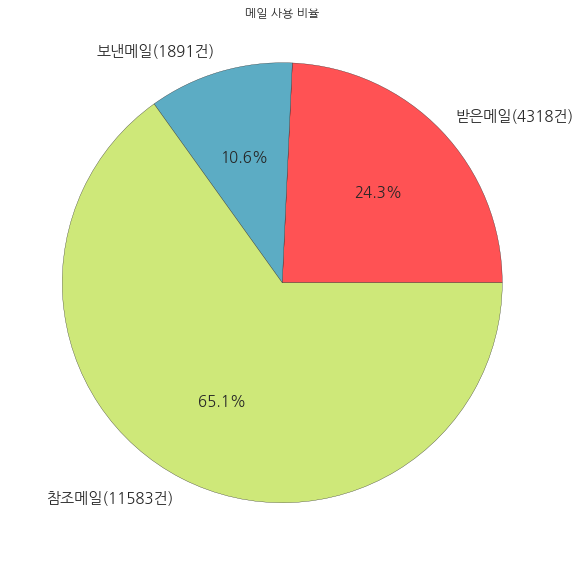

In [8]:
mail_stat_ds = full_mail_ds.groupby('dir').agg({'subject':len}) 
mail_stat_ds.index = mail_stat_ds.index + mail_stat_ds.subject.apply(lambda x : u"(%d건)"%x)
ax = mail_stat_ds.plot( kind='pie', subplots=True , figsize=(8,8), autopct='%.1f%%', colors=col_pal
              , fontsize=15, legend=None, title=u'메일 사용 비율' )
ax[0].set_ylabel('')
plt.tight_layout()
plt.show()

* 나의 보낸 메일에서 기반기술팀이 참조로 포함된 비율은 ?

In [9]:
tmp_send_mail = mail_ds[mail_ds['dir']=='보낸메일']
team_mail = (tmp_send_mail['to']+tmp_send_mail['cc']).apply(lambda x: 1 if (x.find(u'기반기술')>=0) else 0).sum()
total_mail = tmp_send_mail.count()[0]
print(u"나의 보낸메일에 팀이 포함되는 비율 %.3f = %d / %d " % (team_mail / total_mail, team_mail , total_mail))

나의 보낸메일에 팀이 포함되는 비율 0.472 = 892 / 1891 


* 주고 받은 메일 산점도 그리기
* 첨부파일이 제외된 mail_ds사용 

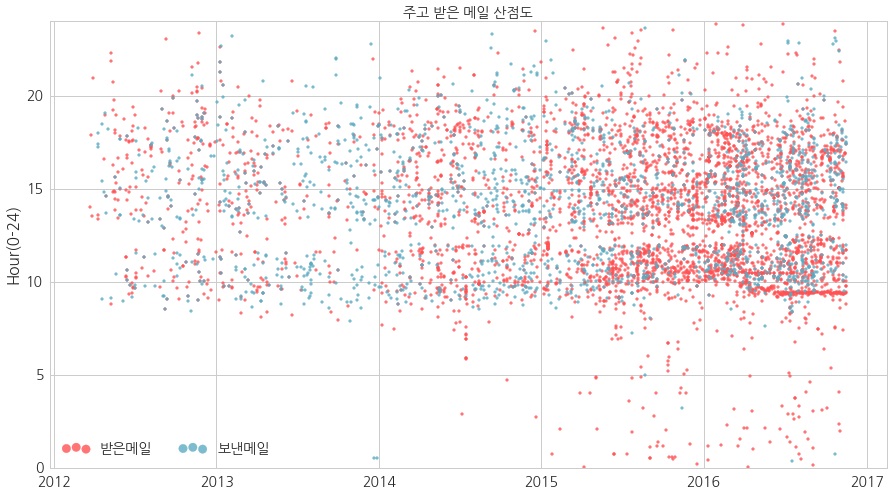

In [10]:
plt.figure(figsize=(15,8))
for (c,(name, group)) in zip(col_pal, mail_ds.groupby('dir')):
    plt.scatter( group['date'].tolist(), group['hour'].tolist(), s=8, alpha=.8, color=c, label=name )

plt.ylim(0,24)
plt.ylabel('Hour(0-24)')
plt.title("주고 받은 메일 산점도",fontsize=14)
plt.legend(scatterpoints=3,
           loc='lower left',
           ncol=3,
           fontsize=14, markerscale = 3) 
plt.show()

* 년단위 주고 받은 메일수

In [11]:
mail_ds.groupby('year').count()[['subject']].T

year,2012,2013,2014,2015,2016
subject,346,507,1030,1858,2468


* 캘런더 행태로 주고 받은 메일량보기 
* 특정기간과 요일에 대하여 패턴을 보기 편함 

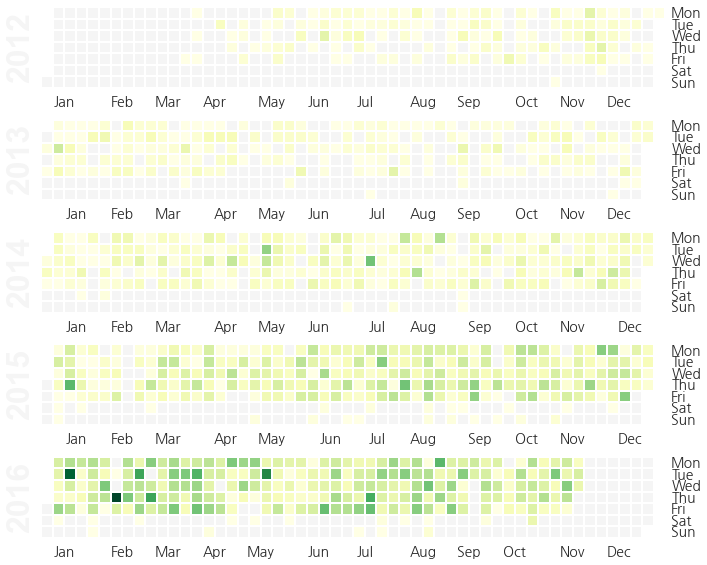

In [12]:
import calmap

for (cm,(name, group)) in zip(['YlGn','Blues'],mail_ds.groupby('total')):
    daily_stat_ds = group.groupby('date').count()['subject']
    daily_stat_ds.index = daily_stat_ds.index.to_datetime()
    calmap.calendarplot(daily_stat_ds,  cmap=cm
                       , fig_kws=dict(figsize=(10, 8)))

* 보낸메일, 받은메일 분포를 대비하여 그려보기 

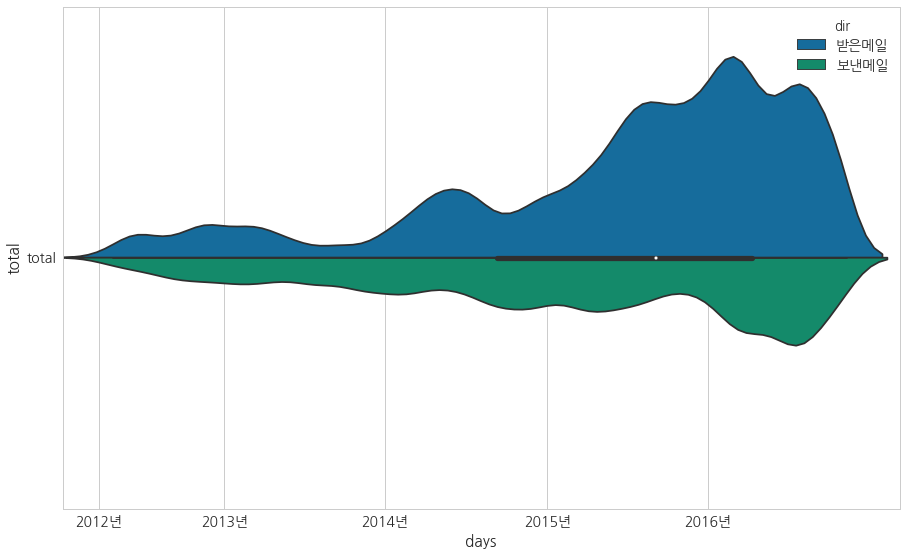

In [13]:
plt.figure(figsize=(15,9))
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.4,
        rc = {'font.size': 12, 'font.family':'NanumGothic'})
sns.violinplot(data=mail_ds[mail_ds['dir'] != u'참조메일'], x='days', y='total', hue='dir',split=True
               , orient='h', width=.8,  cut=2, bw=.1, scale='count', colors=col_pal)
## draw x-ticks
ticks = mail_ds.groupby('year').min()[['days']]
plt.xlim(0,1900)
xticks = plt.xticks( ticks.days.tolist(), [ "%d년" % m for m in ticks.index.tolist()] )


* 년도별 일평균 메일 주고 받은 수 

In [14]:
tmp_ds = mail_ds.groupby(['year','dir']).agg({'subject':len, 'date': lambda x : len(x.unique()) })
tmp_ds['daily_count'] = tmp_ds['subject'] / tmp_ds['date']
tmp_ds = tmp_ds.reset_index().pivot(index='year', columns='dir', values='daily_count').T
tmp_ds.index = [ "일일 " + nm+'수' for nm in tmp_ds.index]
tmp_ds = tmp_ds.applymap(lambda x: round(x,3))
tmp_ds

year,2012,2013,2014,2015,2016
일일 받은메일수,1.964,1.825,3.024,5.612,7.815
일일 보낸메일수,1.585,1.910,2.228,2.190,3.423


* 년도별 메일당 평균 수신자수

In [15]:
tmp_ds = mail_ds.groupby(['year','dir']).agg({'receivers':np.mean}).reset_index().pivot(index='year', columns='dir', values='receivers').T
tmp_ds.index = [nm+'당 수신자수' for nm in tmp_ds.index]
tmp_ds = tmp_ds.applymap(lambda x: round(x,3))
tmp_ds

year,2012,2013,2014,2015,2016
받은메일당 수신자수,1.667,1.922,1.881,3.034,3.276
보낸메일당 수신자수,1.392,1.314,1.420,1.386,1.989


* 시간대별 보낸메일, 받는메일 분포 

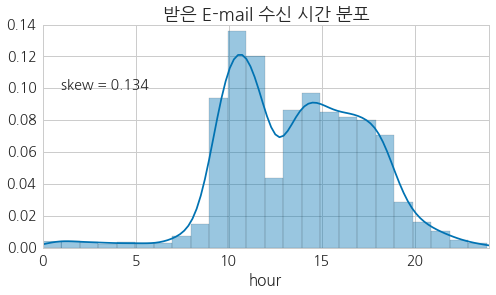

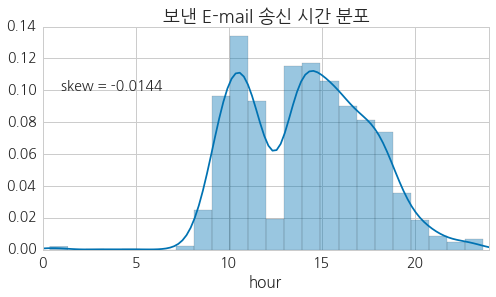

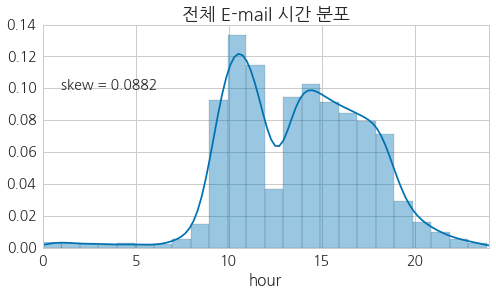

In [16]:
## day 
rcParams['font.family'] = 'NanumGothic'
rcParams.update({'font.size': 12})

def distplot(ds, col, title=''):
    plt.figure(figsize=(8,4))
    sns.distplot (ds[col], bins=24 )
    plt.xlim(0,24)
    skew = ds[(ds[col]>8) & (ds[col]<19 )][col].skew()
    skew = "skew = {0}".format(round(skew, 4))
    plt.text(1,0.1,skew, fontsize=14)
    plt.title(title, fontdict = {'fontsize': 18} )
    plt.show()

distplot(mail_ds[mail_ds['dir']!=u'보낸메일'], 'hour', '받은 E-mail 수신 시간 분포')
distplot(mail_ds[mail_ds['dir']==u'보낸메일'], 'hour', '보낸 E-mail 송신 시간 분포')
distplot(mail_ds, 'hour', '전체 E-mail 시간 분포')


* 메일 응답시간 측정 

In [17]:
## 메일 응답시간 계산 
rtt_list = []

for subject, group in mail_ds[:].groupby('thread_subject'):
    if group.shape[0]==1:
        continue
    group = group.sort('timestamp')
    old = 0
    #print(group)
    for (idx,(ts, mail_dir)) in zip(group.index, group[['timestamp','dir']].values):
        #print(ts,mail_dir)
        if old==0:
            old = (ts,mail_dir)
            continue
        rtt = int((ts-old[0]).total_seconds())


        ## 응답시간 5일 이상 지났거나 5초 미만 메일은 제외 
        if rtt > 5*24*60*60 or rtt < 5:
            old = (ts,mail_dir)
            continue
        ## 내가 보냈거나 또는 내가 받았거나 하는 메일만 선택
        if mail_dir == u'받은메일' and old[1] == u'받은메일':
            old = (ts,mail_dir)
            continue
        old = (ts,mail_dir)
        #print(idx,rtt)
        rtt_list.append((idx,rtt))
        

In [18]:
rtt_ds = pd.DataFrame(rtt_list, columns=['idx','rtt'])
rtt_ds.set_index('idx', inplace=True)
mail_ds = mail_ds.merge(rtt_ds, how='left',left_index=True, right_index=True)

In [19]:
print("메일 평균 응답시간 ")
mail_ds.dropna().groupby(['dir']).mean()[['rtt']] / 60 / 60

메일 평균 응답시간 


,rtt
dir,
받은메일,11.055772
보낸메일,17.002966


* 년도별 일일 메일 전송수와 수신자수 상관 분포 

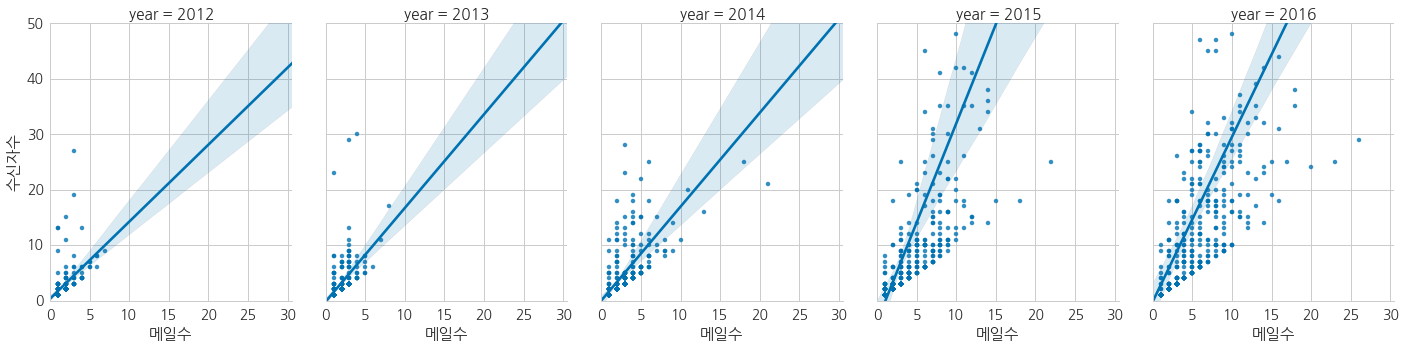

In [20]:
tmp_ds = mail_ds.groupby(['year','year_days','dir']).agg({'receivers':np.sum, 'subject':len}).reset_index()
tmp_ds.columns=['year', 'year_days', 'dir','수신자수', '메일수']

g = sns.lmplot(x="메일수", y="수신자수", data=tmp_ds, col='year',
                palette=col_pal, aspect=.8  )
g.set(ylim=(-.05, 50)).set(xlim=(0, 30.5))


In [21]:
## word cloud by word-frequency 
from os import path
from wordcloud import WordCloud

## draw word cloud by word-corpus 

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(230, 60%%, %d%%)" % random.randint(0, 20)


def drawWordCloud(corpus, figsize=(10,10), max_font_size=None):
    mask = np.array(Image.open('./resource/shape-round-square-long.png'))
    
    wordcloud = WordCloud(width=1000, height=400, margin=2, background_color='white',max_font_size=max_font_size
                          , color_func=grey_color_func , font_path='/Library/Fonts/NanumGothic.ttc'
                          , mask=mask)
    if type(corpus)==str:
        wordcloud = wordcloud.generate(corpus)
    else :
        wordcloud = wordcloud.generate_from_frequencies(corpus)

    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

---
## E-Mail 제목으로 Topic 분석

<img src="https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/Kvs/image/oLD2d3ryYHIGl12-LDd1PG-Q7FY.png">
### 분기별 이메일 Topic 추출 
* 이메일 제목으로 Corpus만들기 

In [22]:
import math

replace_chars = ":_![]/()'\","
exclude_words = set(u"re fw accepted canceled 관현".split())

def tokenize(string):
    string = string.lower()
    for ch in replace_chars:
        string = string.replace(ch, ' ')
    words = [ word for word in string.split() 
                 if (word not in exclude_words) and (len(word)>1) and (not word[0].isnumeric()) 
            ]
    return words

group_func = lambda x: '%d-%02d' % (x.year, math.floor((x.month-1)/3)*3)
def makeCorpus(ds, target):
    corpus = []
    idx2name = []
    
    for (name, group) in ds.groupby(ds['date'].apply(group_func)):
        group_corpus= []
        for string in group[target].values:
            group_corpus.extend(tokenize(string))
        corpus.append(group_corpus)
        idx2name.append(name)
    return (corpus, idx2name)

In [23]:
(subject_corpus, idx2group) = makeCorpus(full_mail_ds[full_mail_ds['dir']=='보낸메일'], 'subject')

* 생성된 Corpus로 TF-IDF 모델생성

In [24]:
from gensim import corpora, models, similarities
from time import time
import operator

dictionary = corpora.Dictionary(subject_corpus)

# compile corpus (vectors number of times each elements appears)
raw_corpus = [dictionary.doc2bow(t) for t in subject_corpus]

# Transform Text with TF-IDF
tfidf = models.TfidfModel(raw_corpus) # step 1 -- initialize a model

* 생성된 모델로 Topic 100개씩 추출 

In [25]:
topic_word_list = []
topic_score_list = []
topic_word_count = 100

for (idx, src_name) in enumerate(idx2group):
    topic = tfidf[raw_corpus[idx]]
    src_name = src_name.lower()
    topic = [ (dictionary[word], score) for (word,score) in topic ]
    topic = sorted(topic, key=operator.itemgetter(1), reverse=True)
    
    topic_word_list.append( [ word for word, score in topic[:topic_word_count]] )
    topic_score_list.append( [ score for word, score in topic[:topic_word_count]] )

In [26]:
topic_score_ds = pd.DataFrame( topic_score_list, index=idx2group )
topic_score_ds.fillna(0, inplace=True)
topic_word_ds = pd.DataFrame( topic_word_list, index=idx2group )
topic_word_ds.fillna('', inplace=True)

## cut letters to 10
topic_word_ds = topic_word_ds.applymap(lambda x: x[:10])

* Hitmap 형태로 그리기 

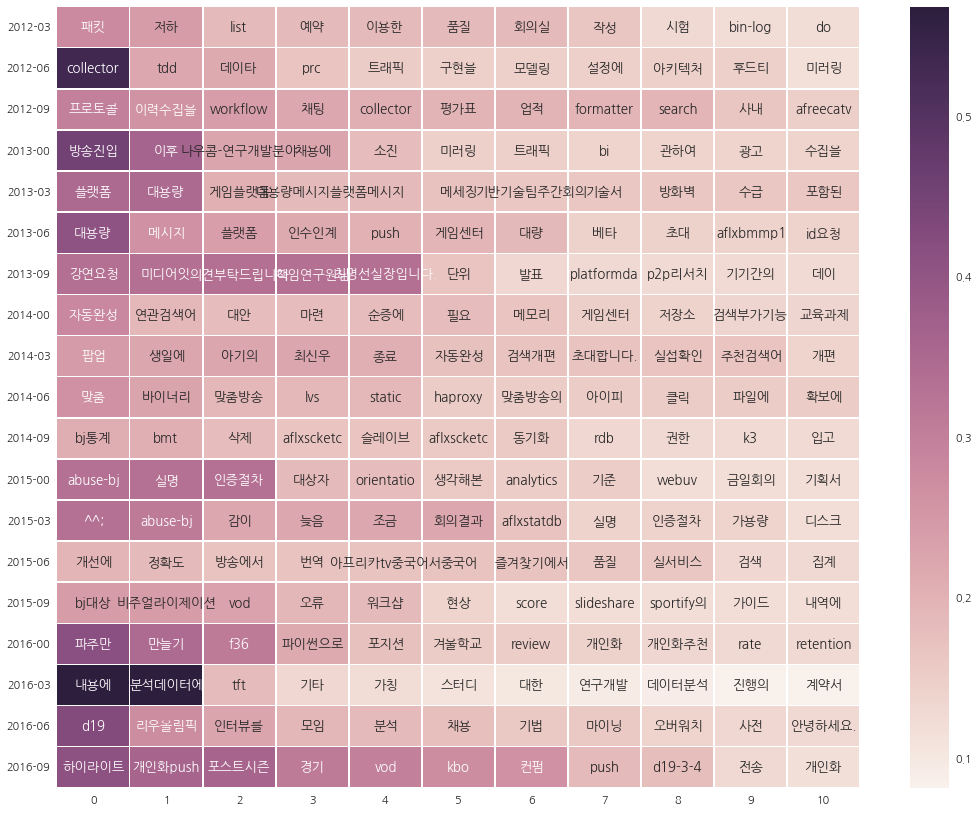

In [27]:
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.1, font='NanumGothic' )
plt.figure(figsize=(18,14))
ax = sns.heatmap(topic_score_ds.ix[:,:10], annot=topic_word_ds.ix[:,:10].values, fmt="", linewidths=.2)

Topic으로 메일의 중요도 스코어를 만들고 중요 메일을 통해 이슈를 정확히 추출하자 

In [28]:
topic_word_score_dict = {}
for doc in topic_word_ds.index:
    topic_word_score_dict[doc] = {w:s for w,s in zip(topic_word_ds.loc[doc].values,topic_score_ds.loc[doc].values)}

In [29]:
def calSubjectScore(subject, topic_dict):
    score = 0
    for word in tokenize(subject):
        score += topic_dict.get(word, 0)
    return score

calSubjectScore( "RE: 기반기술팀 ISMS 실서버 접근제어에 대한 논의의 건 ", topic_word_score_dict['2015-03'] )

0.10935279504850405

In [30]:
mail_ds = mail_ds[mail_ds['timestamp']>'2012-04-01']

In [31]:
## 제목 Score 계산
score_list = []
for day, subject in mail_ds[['date','subject']].values:
    topic2score = topic_word_score_dict[group_func(day)]
    score = calSubjectScore(subject, topic2score)
    score_list.append(score)

mail_ds['topic_score'] = score_list

In [32]:
mail_ds.groupby('thread_subject').agg({'topic_score':max}).sort('topic_score', ascending=False)[:10]

,topic_score
thread_subject,
[개인화Push] KBO 포스트시즌 경기 하이라이트 VOD 개인화 Push 전송 컨펌,2.705473
[개인화Push] KBO 포스트시즌 경기 하이라이트 VOD 전송 오류건 입니다.,2.157930
"[강연요청_의견부탁드립니다]책임연구원님, 미디어잇 최명선실장입니다.",1.675407
대용량 메시지 플랫폼의 대량 모바일 Push 시험을 위한 시험 ID요청,1.627304
2015-05-26 Abuse-BJ 관련 회의결과 ( 조금 늦음 감이 ^^;),1.531203
[게임센터 대용량 메시지 플랫폼] 메모리 저장소 순증에 따른 대안 마련 필요,1.473914
게임센터 대용량 메시지 플랫폼 개발 완료에 따른 시스템 인수인계,1.457268
[F36:파추만] F36 파추만 진행,1.451371
검색개편_자동완성 연관검색어 개발 문서 - 20140218_검색부가기능_연관검색어_자동완성_개발_로드맵.doc,1.436786


<pre>예상보다 나에게 이슈가 있었던 메일과 내용이 잘 추출 된듯하다. 
(시간되시는 분은 해 보시고 잘되시는지 댓글 부탁 드려요)
이번에 분기별 내용을 보면서 그래 이런 일을 했었지... 
내가 4.5년동안 놀지만은 않았구나. 하면서나의 직장 생활 회고를 하게 되었네,, 
</pre>


* 분기별 topic_Score가 가장 높은 이슈메일 추출 

In [33]:
issue_mail_list = []
for name, group in mail_ds.groupby(mail_ds['date'].apply(group_func)):
    tmp_ds = group.groupby('thread_subject').agg({'topic_score':max})
    
    for idx, (sub, score) in enumerate(tmp_ds.sort('topic_score', ascending=False)[:3].reset_index().values):
        issue_mail_list.append([name[:4], name[-2:], idx, sub ])

In [34]:
issue_mail_ds = pd.DataFrame(issue_mail_list, columns=['year','month', 'rank','subject'])
issue_mail_ds = issue_mail_ds.pivot_table(index=['year','rank'], columns='month'
                                          , values='subject',aggfunc=lambda x: x, fill_value='-')
issue_mail_ds.applymap(lambda x:x[:19]+'..')

month                         00                     03  \
year rank                                                 
2012 0                       -..  패킷 분석기반 Access log ..   
     1                       -..  '패킷 기반 분석 시스템' 작성 자..   
     2                       -..  기업맞춤형 정보기술 교육에 관한 조..   
2013 0     검색 이후 방송진입 관련 문의 드립..  대용량 메시지 플랫폼 서버 구성도 ..   
     1     검색 이후 방송진입 관련 협조 요청..  대용량 메시지 플랫폼 기술 리뷰관련..   
     2     [모바일] 검색이후 방송진입 시 검..  대용량 메시지 플랫폼 API 프로토..   
2014 0     [게임센터 대용량 메시지 플랫폼] ..  PC 방송 종료 팝업 추천 방송 안..   
     1     검색개편_자동완성 연관검색어 개발 ..  PC 방송 종료 팝업 추천 방송_ ..   
     2     게임센터 대용량 메시지 플랫폼 메모..  PC 방송 종료 팝업 추천 방송 추..   
2015 0     Abuse-BJ 실명 인증절차 적용..  2015-05-26 Abuse-BJ..   
     1     WebUV 데이터 기준 신규 유입자..  친해지길 바래 - 용인/수원/기타(..   
     2     Data Analytics Orie..  Abuse-BJ 실명 인증절차 적용..   
2016 0     [F36:파추만] F36 파추만 진..  [데이터분석:협업]아프리카TV 분석..   
     1     Canceled: F36 파이썬으로..  아프리카TV 분석데이터에 대한 내용..   
     2     F36 파이썬으로 개인화 추천 시스..  [기타:스터디] 헌터가 제안한 스터..   

month                         06                     09  
year rank                                                
2012 0     실/대/처 Collector 구현을..  채팅 이력수집을 위한 기술 문의 회..  
     1     실/대/처 Collector 구현을..  실/대/처의 AfreecaTV 통합..  
     2     collector 자체개발 vs f..  AfreecaTV 채팅 프로토콜 관..  
2013 0     대용량 메시지 플랫폼의 대량 모바일..  [강연요청_의견부탁드립니다]책임연구..  
     1     게임센터 대용량 메시지 플랫폼 개발..  대용량 메시지 플랫폼 Storage..  
     2     게임센터 대용량 메시지 플랫폼 베타..  모바일 기기간의 p2p리서치 - C..  
2014 0     LVS,HAproxy 테스트를 위한..  aflxscketc1의 슬레이브 서..  
     1     문의하신 플래쉬 플레이서에서의 연관..  BJ통계 table 파티션 등록 및..  
     2     인기방송 static 파일에 시청자..  추천 유사도 생성 쿼리 지연에 따른..  
2015 0     아프리카TV중국어서비스_빠져들만한 ..  검색 시스템 VOD 인덱싱 지연 및..  
     1     검색 품질 개선 작업의 실서비스 적..  "검색 시스템 VOD 인덱싱 지연 ..  
     2     승인됨:  파이_최규민 검색 품질 ..  2015 BJ대상 데이터 비주얼라이..  
2016 0     [D19:모임]D19 7월-2주차 ..  [개인화Push] KBO 포스트시즌..  
     1     [데이터분석:D19] D19 2회 ..  [개인화Push] KBO 포스트시즌..  
     2     아프리카TV 데이터 분석 업무 채용..  [데이터분석] 개인화 시청 성향 따..

---
## 3. E-Mail Network 분석


* 이메일 From, To Tokenize

In [35]:
def simplizeName(name):
    remove_chars = ' "\'#'
    for ch in remove_chars:
        name = name.replace(ch, '')
    name = name.split('_')[-1]
    name = name.split('(')[0]
    name = name.split('@')[0]
    return name[:14]

def tokenizeNames(names):
    names = names.split(';')
    return [ simplizeName(name) for name in names]

mail_ds['from'] = mail_ds['from'].apply(tokenizeNames)
mail_ds['to'] = mail_ds['to'].apply(tokenizeNames)

full_mail_ds['from'] = full_mail_ds['from'].apply(tokenizeNames)
full_mail_ds['to'] = full_mail_ds['to'].apply(tokenizeNames)

In [36]:
email_names = defaultdict(int)
for names in full_mail_ds.from_to[:]:
    for name in names:
        name = simplizeName(name)
        email_names[name] += 1

In [37]:
name_list_ds = pd.DataFrame.from_dict(email_names, orient='index')
name_list_ds = name_list_ds.reset_index()
name_list_ds.columns = ['name','hits']

이름과 소속 데이터를 만들기
* 이메일을 이름만 모두 추출하고 
* 한땀한땀 이름-소속을 매칭하는 CSV파일을 만듦

In [38]:
name_filepath = "./resource/name-info.csv"
name_ds = pd.read_csv(name_filepath)
name_ds.set_index('name', inplace = True)
name2departement = name_ds.to_dict()['department']

메일 보낸사람, 받는사람 이름은 통일화(간소화)

메일을 많이 보낸사람 

In [39]:
def countName(name_addresses):
    name2count = defaultdict(int)
    for names in name_addresses:
        for name in names:
            name2count[name] += 1
            
    ds = pd.DataFrame.from_dict(name2count, orient='index').reset_index()
    ds.columns = ['name','frequency']
    return ds.sort('frequency', ascending=False)

In [40]:
def displayName(name, replace_char='#'): 
    if name in (u'최규민', 'ME'):
        return name
    
    display_name = ''
    for (idx, ch) in enumerate(name):
        display_name += (ch if idx%2==0 else replace_char)
    
    return display_name

def drawNameCloud(corpus):
    corpus = [(displayName(name),score) for (name,score) in corpus]
    drawWordCloud(corpus, max_font_size=250)

In [41]:
recv_user_ds = countName(mail_ds[mail_ds['dir']==u'받은메일']['from'])
send_user_ds = countName(mail_ds[mail_ds['dir']==u'보낸메일']['to'])

* 받은 메일 상위 50명

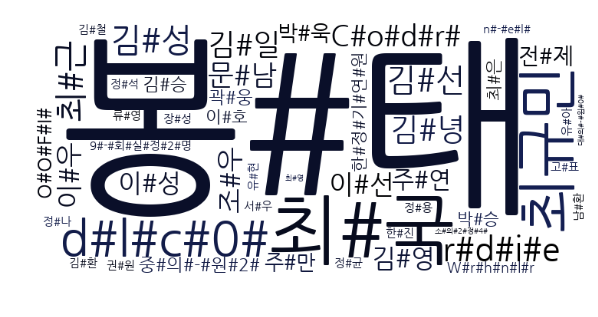

In [42]:
drawNameCloud(recv_user_ds[:50].values)

* 보낸 메일 상위 50명

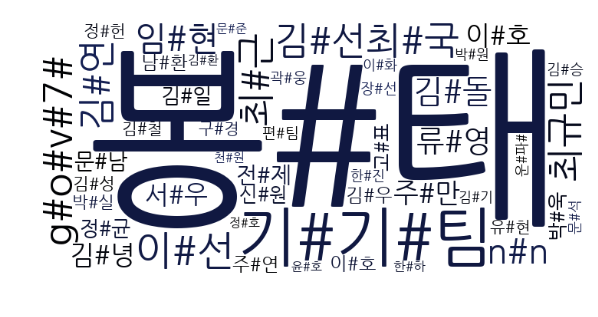

In [43]:
drawNameCloud(send_user_ds[:50].values)

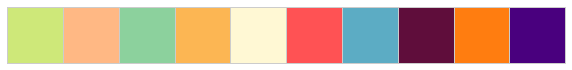

In [44]:
col_pal = "#CEE879 #FFB884 #8CD19D #FCB653 #FFF8D4 #FF5254 #5CACC4  #5F0D3B #FF7D10 #49007E".split()
sns.palplot(col_pal)

In [45]:
departments = name_ds['department'].unique()
department2color = { part:col for (col, part) in zip(col_pal, departments) }

In [46]:
name_dic = { 'name':{}, 'display':{}, 'color':{}, 'part':{} }
for (name, row) in name_ds.iterrows():
    name = str(name)
    name_dic['name'][name] = name
    name_dic['display'][name] = displayName(name, 'x')
    name_dic['color'][name] = department2color.get(row.department,col_pal[3] )
    name_dic['part'][name] = row.department

for (part,col) in department2color.items():
    name_dic['name'][part] = part
    name_dic['color'][part] = col
    name_dic['display'][part] = displayName(part, 'x')
    name_dic['part'][part] = part


In [47]:
# network 형태의 데이터를 만들기위해 이메일의 from, to로 부터 edge,node를 만든다. 
def toDisplay(name, item='name', default=False):
    if item=='bypass':
        return name
    
    r = name_dic[item].get(name, default)
    if r==False:
        return False 
    return r

def makeNetworkInfo(mail_ds, threshold=0):
    edges = defaultdict(int)
    for (idx,row) in mail_ds.iterrows():
        f = str(row['from'][0])
        if f == False:
            continue
        t = row['to']
        if t!=t or f!=f:  #nan check
            continue
        for tt in t:
            if tt == False:
                continue
            tt = str(tt)
            edges[(f,tt) if f<tt else (f,tt)] += 1
    
    edges = cutEdges(edges, threshold)
    nodes = edges2nodes(edges)

    return (edges, nodes)

In [48]:
from sklearn import preprocessing

def rescaling(arr):
    min_max_scaler = preprocessing.MinMaxScaler()
    arr_minmax = min_max_scaler.fit_transform(arr)
    return arr_minmax

In [49]:
def drawNetwork( nodes, edges, title='', distance=0.8 , legend=[], figsize=(17,12), img_path='./resource/image/nw.png'
               , view_type='display'):
    G=nx.Graph()
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=14)
    plt.xlim(-.02,1.02)
    plt.ylim(-.05,1.05)
    edge_list = []
    for (k,v) in edges.items():
        if k[0] in nodes and k[1] in nodes:
            G.add_edge(k[0],k[1],weight=v)
    
    edge_list = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > 1]
    colors= ([ toDisplay(u, item='color',default='k') for u in nodes.keys() ])
    pos=nx.spring_layout(G, k=distance) # positions for all nodes   

    maxSize = max(nodes.values())
    nx.draw_networkx_nodes(G,pos,
                           nodelist=[n for n in nodes.keys()],
                           node_color=colors,
                           node_size=[(v/maxSize)*5000 for v in nodes.values()],
                           alpha=0.5)

    edge_width = rescaling([[w]for w in edges.values()])
    nx.draw_networkx_edges(G, pos, alpha=0.4,edgelist=edge_list, width=(edge_width*10+.3))
    labels = {}
    cnt = 0
    for n in nodes.keys():
        labels[n]= toDisplay(n,item=view_type,default='unknown')
        cnt += 1

    nx.draw_networkx_labels(G,pos,labels,font_size=14,font_color="k", font_family='NanumGothic')

    plt.title(title, fontsize=14)
    ## add patches 
    patches  = []
    for (name, color) in legend:
        patches.append( mpatches.Patch(color=color, label=name, alpha=0.7) )
    plt.legend(handles = patches, fontsize=14)
        
    plt.savefig(img_path, dpi=None, facecolor='w', edgecolor='w', 
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None)
    
    plt.show()

In [50]:
def cutEdges( edges, threshold=0 ):
    return { (n1,n2):w for (n1,n2), w in edges.items() if ((w > threshold )and (n1!='최규민') and (n2!='최규민'))}

def cutEdges( edges, threshold=0 ):
    return { (n1,n2):w for (n1,n2), w in edges.items() if ((w > threshold ))}
        
    
def edges2nodes( edges ):
    nodes = defaultdict(int)
    for (n1,n2), w in edges.items():
        nodes[n1] += w
        nodes[n2] += w
    return nodes

In [51]:
(edges, nodes) = makeNetworkInfo(mail_ds[:])

In [52]:
legend= [(n,c) for n,c in department2color.items()]

* 년도별 Network를 그리고, 해당 Plot을 파일로 저장한다. 

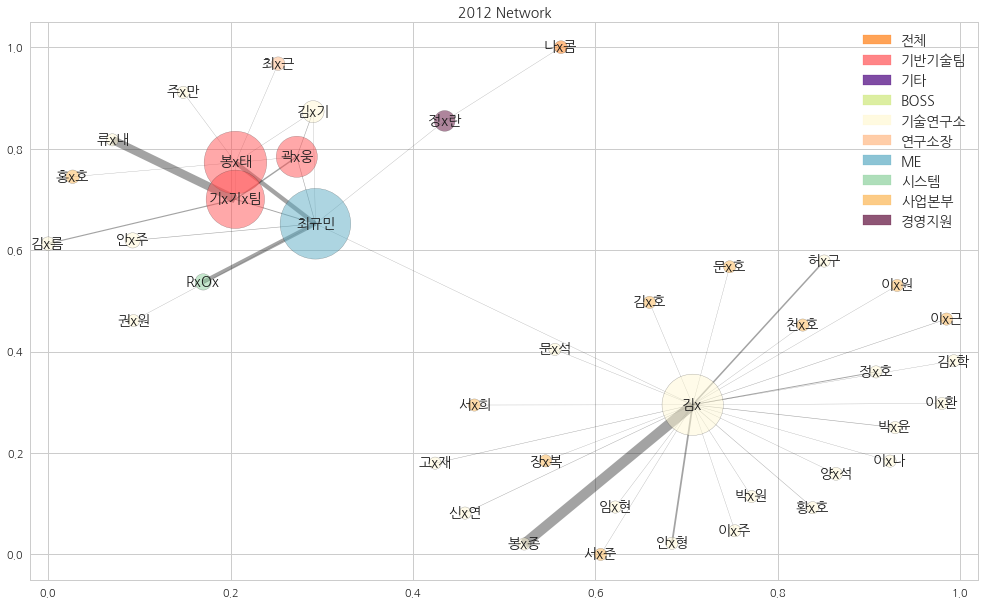

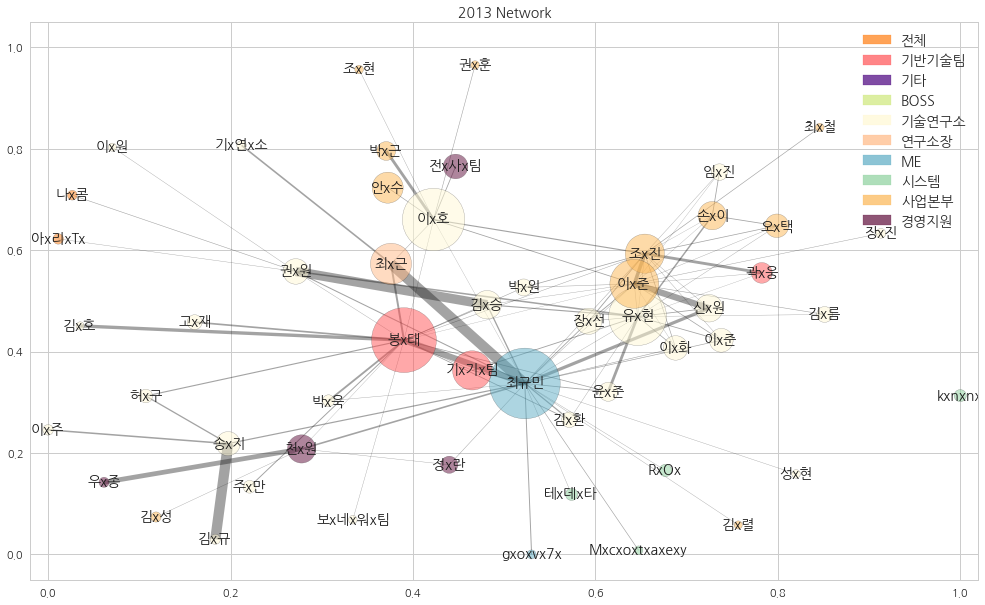

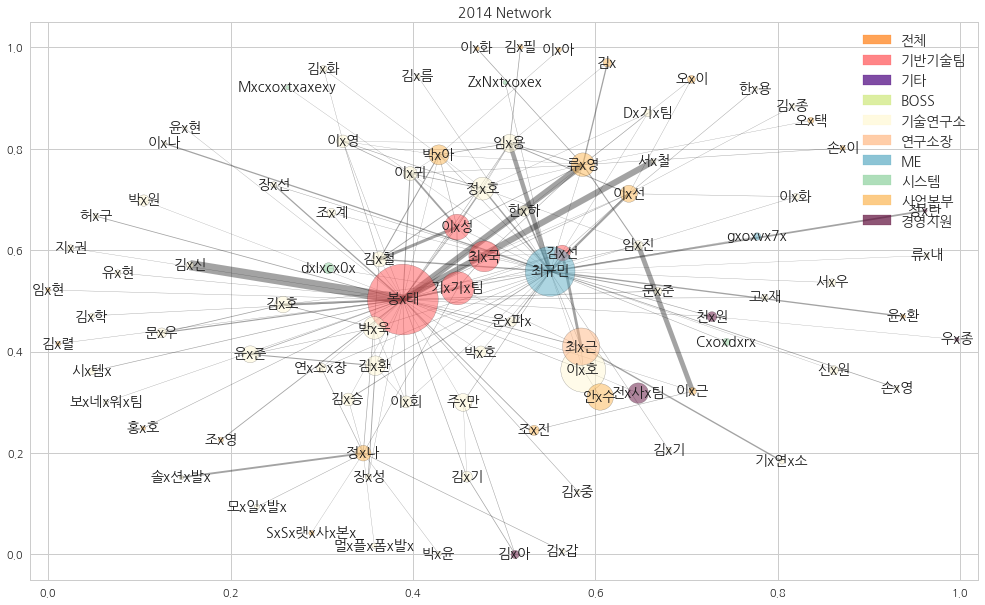

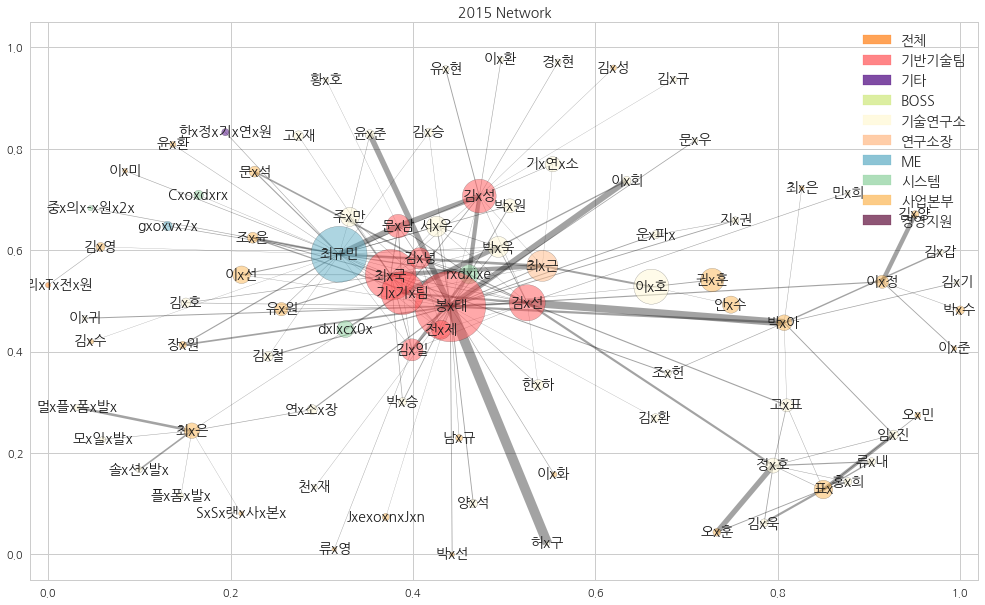

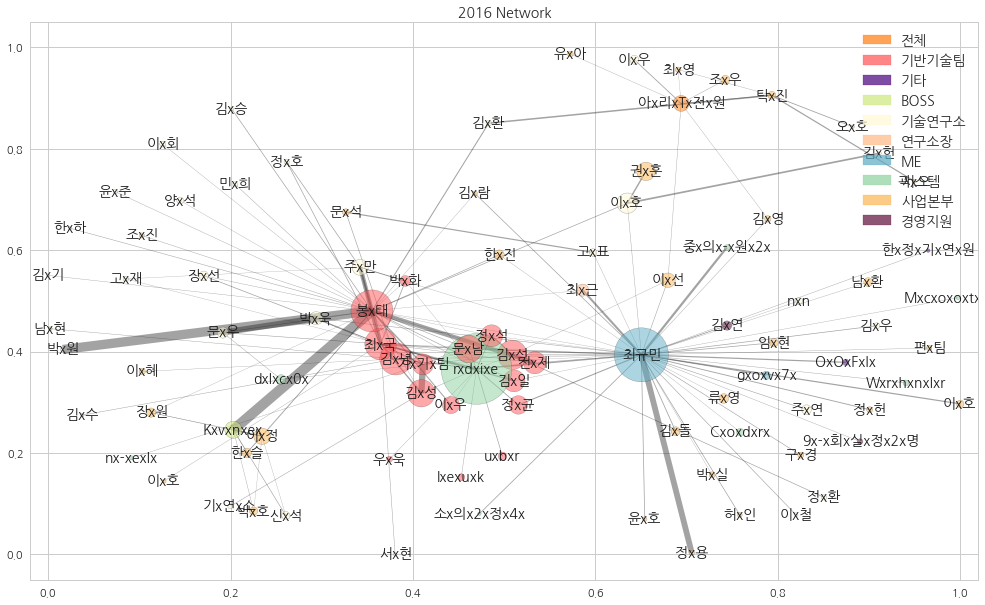

In [53]:
base_path = './resource/image/'
for (name, group) in full_mail_ds.groupby('year'):
    (edges, nodes) = makeNetworkInfo(group, 8)
    fn = base_path + 'network-graph-year-' +str(name)+'.png' 
    drawNetwork(nodes, edges, distance=.25, title = str(name) + ' Network'
                , figsize=(17,10), legend=department2color.items(), img_path=fn)

* 받은메일, 보낸메일, 참조메일에 따른 네트워크 

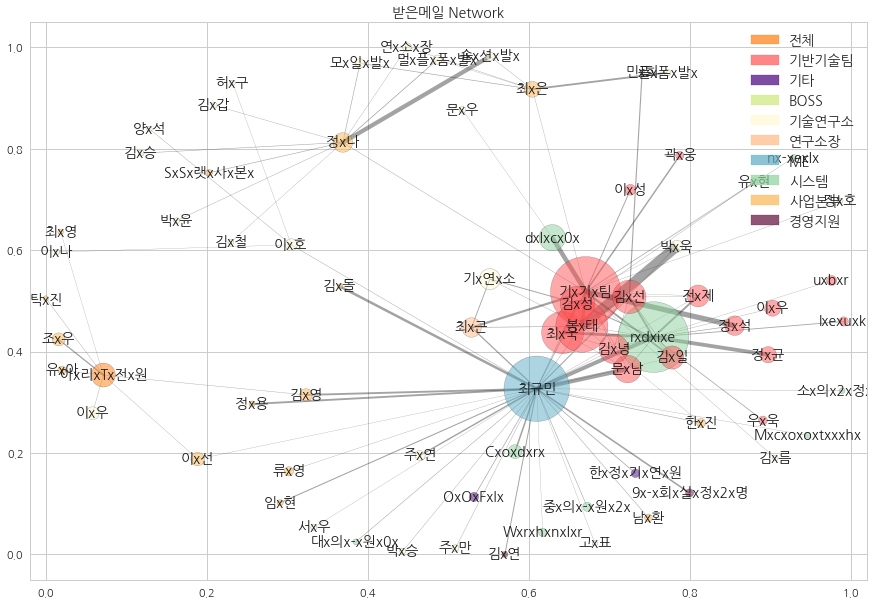

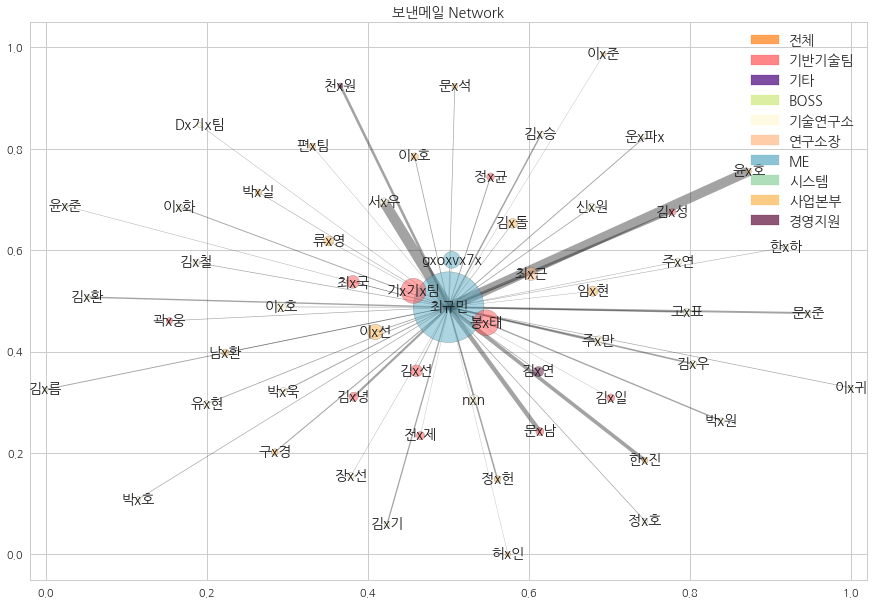

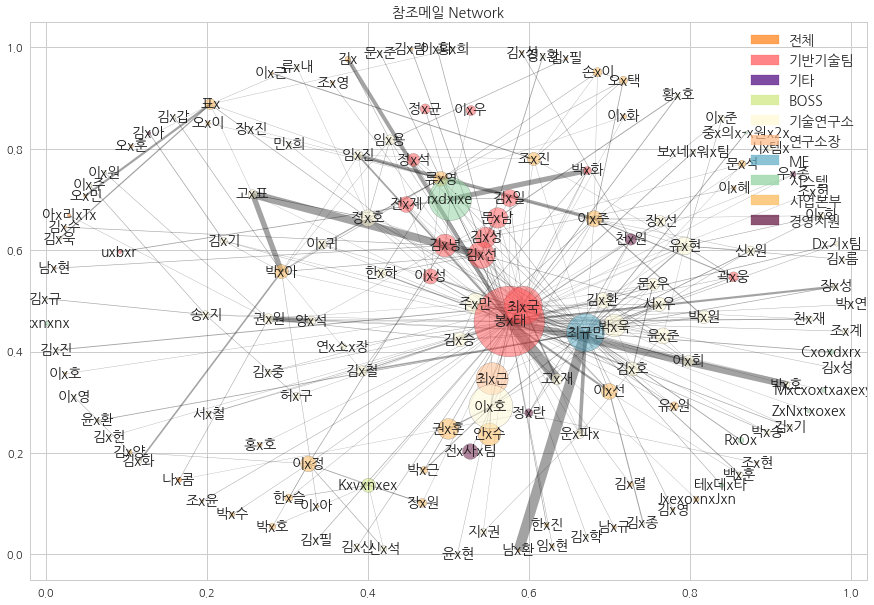

In [54]:
for (name, group) in full_mail_ds.groupby('dir'):
    (edges, nodes) = makeNetworkInfo(group, 10)
    fn = base_path + 'network-graph-year-' +str(name)+'.png' 
    drawNetwork(nodes, edges, distance=.3, title = str(name) + ' Network', figsize=(15,10), legend=legend, img_path=fn)

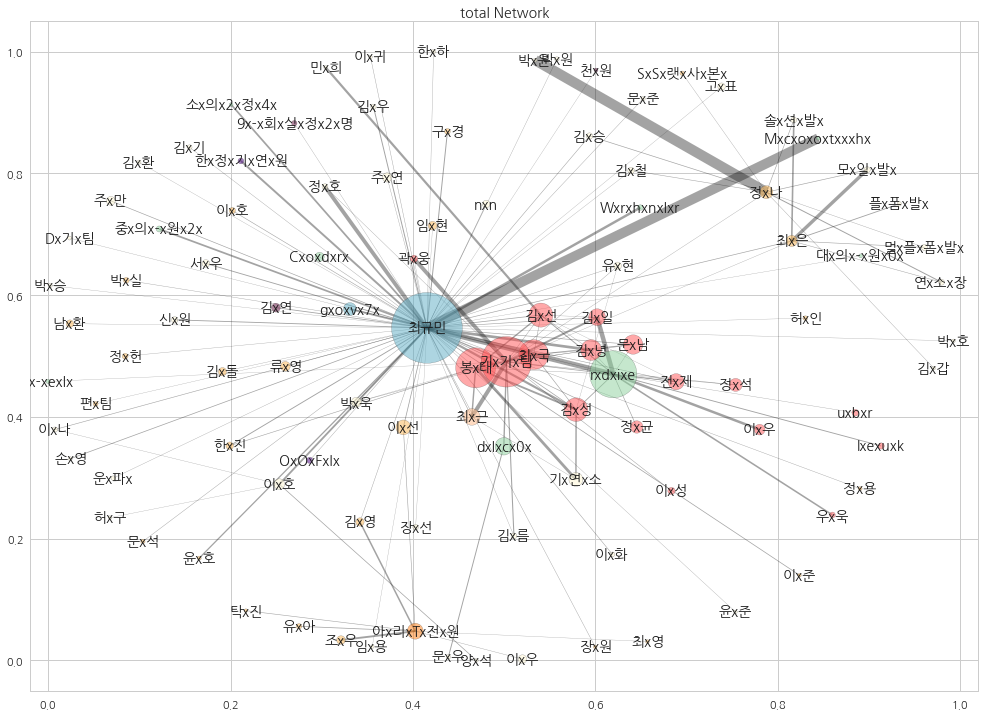

In [55]:
for (name, group) in mail_ds.groupby('total'):
    (edges, nodes) = makeNetworkInfo(group, 10)
    drawNetwork(nodes, edges, distance=.3, title = str(name) + ' Network', figsize=(17,12))

* 중심성(Centrality) 측정해보기  

In [56]:
# (edges, nodes) = extractNetwork(ds=sw_ds[sw_ds.episode>0], name1='actor', name2='place1', min_node=15)
def calNetworkCentrality(nodes, edges, method=nx.centrality.closeness_centrality, topn=10):
    G=nx.Graph()
    for (n,v) in edges.items():
        G.add_edge(n[0],n[1],weight=v)
        
    for (n,v) in nodes.items():
        G.add_node(n,weight=v)
    
    
    #dc = nx.betweenness_centrality(G)
    #dc = nx.degree_centrality(G)
    dc = method(G)
    
    import operator
    sorted_x = sorted(dc.items(), key=operator.itemgetter(1))
    sorted_x.reverse()


    for n,c in sorted_x[:topn]:
        print(n,'\t',round(c,4))
    return sorted_x[:topn]

* closeness centrality를 측정해 본다. 

In [57]:
for (name, group) in full_mail_ds.groupby('year'):
    (edges, nodes) = makeNetworkInfo(group, 10)
    print(name,"******************* ")
    calNetworkCentrality(nodes, edges, method=nx.centrality.closeness_centrality)

2012 ******************* 
최규민 	 0.75
봉승태 	 0.6923
기반기술팀 	 0.6429
곽정웅 	 0.6
ROOM 	 0.45
정미란 	 0.45
안현주 	 0.45
홍승호 	 0.4286
최동근 	 0.4286
김아름 	 0.4091
2013 ******************* 
최규민 	 0.6308
이승준 	 0.5467
봉승태 	 0.5395
유의현 	 0.4824
이민호 	 0.4824
김종승 	 0.4607
윤오준 	 0.4362
이윤준 	 0.4362
신숙원 	 0.4362
이근화 	 0.4362
2014 ******************* 
봉승태 	 0.6723
최규민 	 0.5755
류대영 	 0.4878
이귀성 	 0.4848
최재국 	 0.4734
기반기술팀 	 0.4706
정진호 	 0.4651
임호용 	 0.4651
박선아 	 0.4571
김종승 	 0.4571
2015 ******************* 
봉승태 	 0.5382
최규민 	 0.5008
최재국 	 0.4713
기반기술팀 	 0.4653
김래선 	 0.4593
김도성 	 0.4217
박영욱 	 0.4193
김태녕 	 0.4169
김백일 	 0.4169
전민제 	 0.4169
2016 ******************* 
최규민 	 0.6296
봉승태 	 0.5782
최재국 	 0.506
redmine 	 0.5
기반기술팀 	 0.4802
김태녕 	 0.4775
김래선 	 0.467
김백일 	 0.4545
정경석 	 0.4521
문경남 	 0.4521


팀기준으로 네트워크 그려보기 

In [58]:
team_members = set(name_ds[name_ds.department=='기반기술팀'].index.values)
team_members.add(u'기반기술팀')
team_members.add(u'최규민')
#team_members.add('redmine')

(edges, nodes) = makeNetworkInfo(full_mail_ds, 1)

filtered_edges = {}
filtered_nodes = defaultdict(int)
for (edge, weight) in edges.items():
    if (edge[0] in team_members) and (edge[1] in team_members):
        filtered_edges[edge] = weight
        filtered_nodes[edge[0]] += weight
        filtered_nodes[edge[1]] += weight


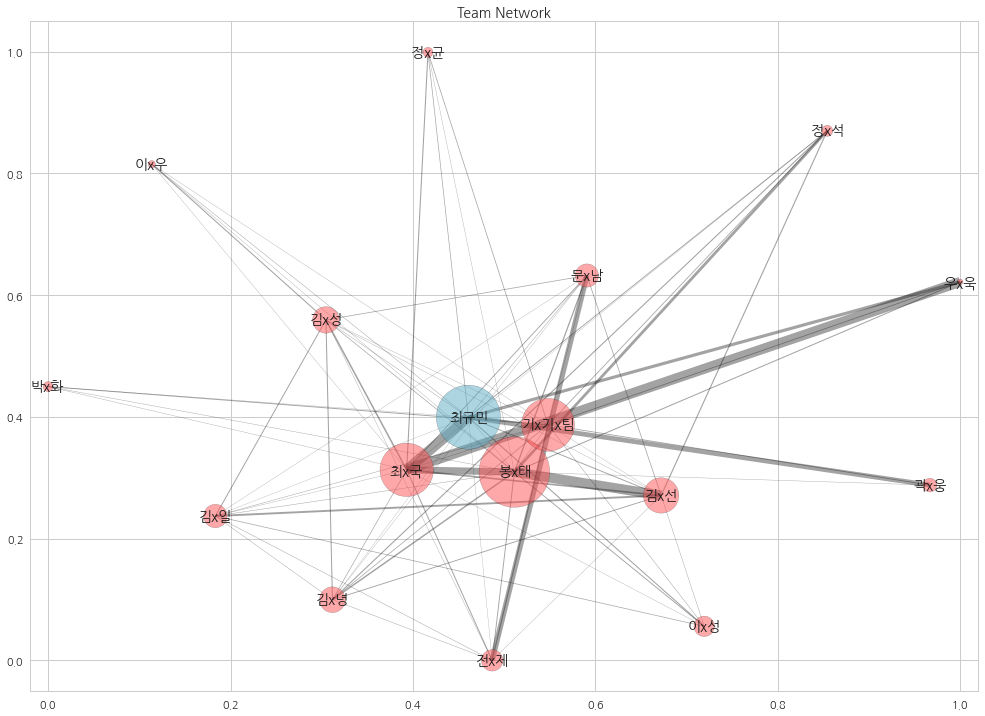

In [59]:
drawNetwork(filtered_nodes, filtered_edges, distance=1., title ='Team Network', figsize=(17,12), 
            img_path='team_network.png', view_type='display') 

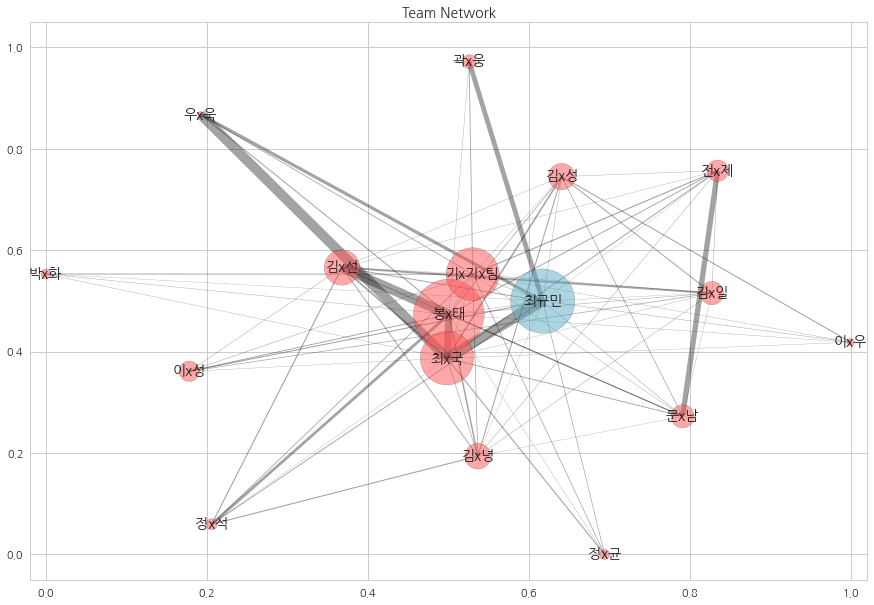

In [60]:
drawNetwork(filtered_nodes, filtered_edges, distance=1., title ='Team Network', figsize=(15,10), 
            img_path='team_network.png', view_type='display') 

부서 기준으로 그려보기 

In [61]:
def makeTeamNetworkInfo(mail_ds, threshold=0):
    edges = defaultdict(int)
    for (idx,row) in mail_ds.iterrows():
        f = str(row['from'][0])
        
        f = toDisplay(f, item='part')
        
        if f == False:
            continue
        t = row['to']
        if t!=t or f!=f:  #nan check
            continue
        for tt in t:
            if tt == False:
                continue
            tt = toDisplay(str(tt), item='part', default=str(tt)) 
            edges[(f,tt) if f<tt else (f,tt)] += 1
    
    edges = cutEdges(edges, threshold)
    nodes = edges2nodes(edges)

    return (edges, nodes)

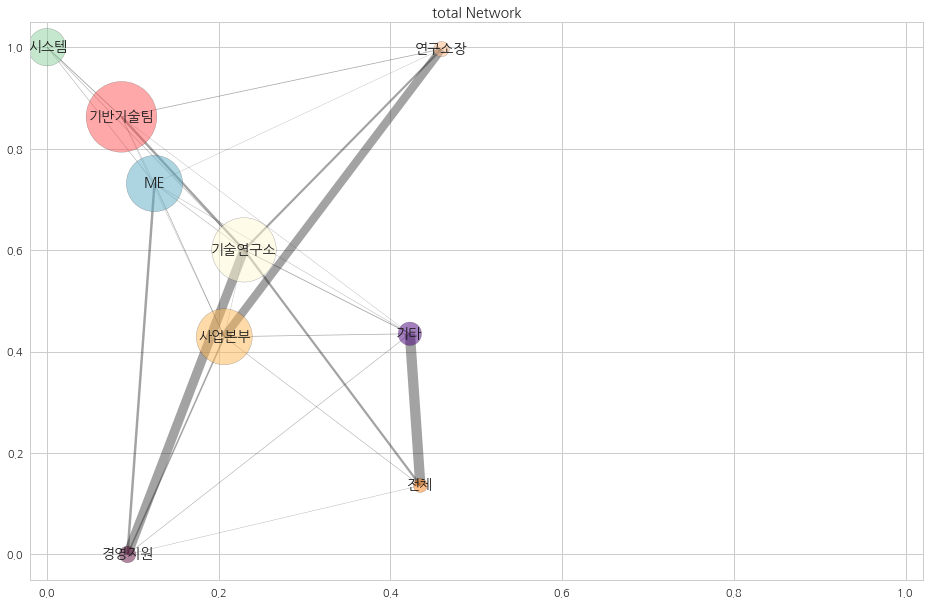

In [62]:
for (name, group) in mail_ds.groupby('total'):
    (edges, nodes) = makeTeamNetworkInfo(group, 10)
    drawNetwork(nodes, edges, distance=1.5, title = str(name) + ' Network', figsize=(16,10), view_type='bypass')